## Setup

In [16]:
import os
os.getcwd()
sys.path

['../',
 '../auth',
 '../code',
 '/Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/code',
 '/Users/wax/opt/anaconda3/lib/python38.zip',
 '/Users/wax/opt/anaconda3/lib/python3.8',
 '/Users/wax/opt/anaconda3/lib/python3.8/lib-dynload',
 '',
 '/Users/wax/opt/anaconda3/lib/python3.8/site-packages',
 '/Users/wax/opt/anaconda3/lib/python3.8/site-packages/aeosa',
 '/Users/wax/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions',
 '/Users/wax/.ipython']

In [18]:
%load_ext autoreload
%autoreload 2

from random import random
import pandas as pd
import matplotlib
import numpy as np
from sklearn import metrics
import csv
import time
import itertools
from dateutil.relativedelta import relativedelta

from alpha_vantage.timeseries import TimeSeries
import pandas_market_calendars as mcal


import pmdarima as pya
import prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from pathlib import Path
# import os
# current_path = os.getcwd()
# # top = Path(__file__ + '..').resolve()
import sys
# sys.path.insert(0, top/ 'code')
# sys.path.insert(0, top/ 'auth')
sys.path.insert(0, '../code')
sys.path.insert(0, '../auth')
sys.path.insert(0, '../')

# arrow = top / 'assets/arrow.png'
# print('source image:', arrow)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Functions loaded.


# Alpha Vantage

## EDA

In [6]:
ts = TimeSeries(key=av_key, output_format='csv')
AV_COLUMNS = ['time', 'open', 'high', 'low', 'close', 'volume']

### Gather Data

In [7]:
# df_full = get_av_all_data_slices('SPY', ts, verbose=1)
# df_full.to_csv('../data/SPY_2019_2021.csv')

Requesting all data slices for SPY...

0 0
Requesting slice: year1month1
First record:
                       open    high     low   close volume
time                                                      
2021-04-26 20:00:00  417.66  418.04  417.58  417.95  53372
Last record:
                       open    high     low   close volume
time                                                      
2021-03-29 05:00:00  394.03  394.03  393.19  393.68  87585
Processed and appended year1month1 to DataFrame.

0 1
Requesting slice: year1month2
First record:
                      open    high     low   close volume
time                                                     
2021-03-26 20:00:00  395.5  395.72  395.41  395.63  64946
Last record:
                              open           high            low  \
time                                                               
2021-02-26 05:00:00  382.843983138  382.843983138  381.687776367   

                            close volume  
time         

First record:
                              open           high            low  \
time                                                               
2020-05-29 20:00:00  301.062728359  301.239870393  301.023363463   

                             close  volume  
time                                        
2020-05-29 20:00:00  301.239870393  122070  
Last record:
                              open           high            low  \
time                                                               
2020-05-04 05:00:00  276.105383984  276.656492535  275.268879934   

                             close  volume  
time                                        
2020-05-04 05:00:00  275.357450951  114843  
Processed and appended year1month12 to DataFrame.

1 0
Requesting slice: year2month1
First record:
                              open           high            low  \
time                                                               
2020-05-01 20:00:00  278.359024308  278.447595325  278.280

Re-requesting slice: year2month10
First record:
                              open           high            low  \
time                                                               
2019-08-05 20:00:00  269.826082708  270.513969669  268.731276699   

                             close  volume  
time                                        
2019-08-05 20:00:00  269.283523978  515412  
Last record:
                             open          high            low          close  \
time                                                                            
2019-07-08 05:00:00  288.34089937  288.49591615  288.244013883  288.244013883   

                    volume  
time                        
2019-07-08 05:00:00   8514  
Processed and appended year2month10 to DataFrame.

1 10
Requesting slice: year2month11
First record:
                              open           high            low  \
time                                                               
2019-07-05 20:00:00  288.815638

In [151]:
df_last = get_av_all_data_slices('SPY', ts, y=1, m=1, verbose=1)
df_last.index = pd.to_datetime(df_last.index)
df_last.to_csv('../data/SPY_Last_Month.csv')

Requesting all data slices for SPY...

0 0
Requesting slice: year1month1
First record:
                       open    high     low   close volume
time                                                      
2021-04-27 20:00:00  417.79  417.93  417.63  417.64  23457
Last record:
                       open    high     low   close volume
time                                                      
2021-03-29 05:00:00  394.03  394.03  393.19  393.68  87585
Processed and appended year1month1 to DataFrame.

Finished getting all data slices for SPY


In [19]:
# Get NYSE calendar
NYSE = mcal.get_calendar('NYSE')
early = NYSE.schedule(start_date='2012-07-01', end_date='2012-07-10')
early;

In [86]:
# ticker = 'SPY'
# date= 'year1month10'
# apiKey = av_key

# df_new = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol='+ticker+'&interval=60min&slice='+date+'&apikey='+apiKey+'&datatype=csv&outputsize=full') 

In [87]:
# df_new.set_index('time', inplace=True)
# df_new.index = pd.to_datetime(df_new.index)
# df_new[(df_new.index>'2020-07-03') & (df_new.index<'2020-07-04')]

,open,high,low,close,volume
time,,,,,


## Load Data from File

In [28]:
# df_full = pd.read_csv('../data/SPY_2019_2021_CBH.csv', index_col='time')
df_full = pd.read_csv('../data/SPY_2019_2021_CBD.csv', index_col='time')
df_full.index = pd.to_datetime(df_full.index)

In [99]:
# df_full = pd.read_csv('../data/SPY_2019_2021_CBH.csv', index_col='time')
df_last = pd.read_csv('../data/SPY_Last_Month.csv', index_col='time')
df_last.index = pd.to_datetime(df_last.index)

## Data Exploration

In [17]:
df_full.isna().sum()

open      311
high      311
low       311
close     311
volume    311
dtype: int64

## Set Up Frequency Variables

In [22]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

In [20]:
cbd = pd.offsets.CustomBusinessDay(calendar=NYSE)
cbd

<CustomBusinessDay>

### Using Custom Business Day

In [29]:
df_full = df_full.sort_index()
df_full = df_full.asfreq(cbd)

### Using Custom Business Hour

In [100]:
df_last = df_last.sort_index()
df_last = df_last.asfreq(cbh)

In [20]:
# try:
#     assert(type(df_new)=='pandas.core.frame.DataFrame')
# except AssertionError:
#     print('Nothing to append.')
# else:
#     df_full = df_full.append(df_new)
#     df_full = df_full.sort_index()
#     df_full = df_full.asfreq(cbh)
#     df_full.to_csv('../data/SPY_2019_2021.csv')
# finally:
#     df_full = df_full.sort_index()
#     df_full = df_full.asfreq(cbh)
#     df_full.to_csv('../data/SPY_2019_2021.csv')
#     df_full

Nothing to append


In [102]:
vol_last = df_last.volume
vol_last[-16:]

time
2021-04-27 05:00:00        7812.0
2021-04-27 06:00:00       36057.0
2021-04-27 07:00:00       53215.0
2021-04-27 08:00:00       76612.0
2021-04-27 09:00:00      175471.0
2021-04-27 10:00:00     8105156.0
2021-04-27 11:00:00     7452516.0
2021-04-27 12:00:00     5857072.0
2021-04-27 13:00:00     4650285.0
2021-04-27 14:00:00     2477993.0
2021-04-27 15:00:00     6479249.0
2021-04-27 16:00:00    12748451.0
2021-04-27 17:00:00     2367583.0
2021-04-27 18:00:00       55149.0
2021-04-27 19:00:00       70724.0
2021-04-27 20:00:00       23457.0
Freq: CBH, Name: volume, dtype: float64

In [112]:
df = df_full.close
df_last = df_last.close
df_last[-16:]

time
2021-04-27 05:00:00    418.0100
2021-04-27 06:00:00    417.5200
2021-04-27 07:00:00    417.9900
2021-04-27 08:00:00    417.9400
2021-04-27 09:00:00    417.7800
2021-04-27 10:00:00    416.8450
2021-04-27 11:00:00    417.1600
2021-04-27 12:00:00    417.5350
2021-04-27 13:00:00    417.0900
2021-04-27 14:00:00    417.3933
2021-04-27 15:00:00    417.6100
2021-04-27 16:00:00    417.4875
2021-04-27 17:00:00    417.6500
2021-04-27 18:00:00    417.5700
2021-04-27 19:00:00    417.7000
2021-04-27 20:00:00    417.6400
Freq: CBH, Name: close, dtype: float64

In [32]:
df_full.index, df.index, df_last.index

(DatetimeIndex(['2019-05-07 05:00:00', '2019-05-08 05:00:00',
                '2019-05-09 05:00:00', '2019-05-10 05:00:00',
                '2019-05-13 05:00:00', '2019-05-14 05:00:00',
                '2019-05-15 05:00:00', '2019-05-16 05:00:00',
                '2019-05-17 05:00:00', '2019-05-20 05:00:00',
                ...
                '2021-04-12 05:00:00', '2021-04-13 05:00:00',
                '2021-04-14 05:00:00', '2021-04-15 05:00:00',
                '2021-04-16 05:00:00', '2021-04-19 05:00:00',
                '2021-04-20 05:00:00', '2021-04-21 05:00:00',
                '2021-04-22 05:00:00', '2021-04-23 05:00:00'],
               dtype='datetime64[ns]', name='time', length=514, freq='C'),
 DatetimeIndex(['2019-05-07 05:00:00', '2019-05-08 05:00:00',
                '2019-05-09 05:00:00', '2019-05-10 05:00:00',
                '2019-05-13 05:00:00', '2019-05-14 05:00:00',
                '2019-05-15 05:00:00', '2019-05-16 05:00:00',
                '2019-05-17 05:00:00

## Test out read and write CSV at same time

In [ ]:
with open('../data/GME_intra_Mar_29_Apr_12.csv', newline='') as csvfile:
#     fieldnames = ['first_name', 'last_name']
    reader = csv.reader(csvfile)
    fieldnames = next(reader)
    print(fieldnames)
    
    with open('../data/output.csv', mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(fieldnames)
        for row in reader:
            writer.writerow(row)
            

## More EDA

In [73]:
df_full[df_full.index>'2020-07-03']

,open,high,low,close,volume
time,,,,,
2020-07-03 05:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 06:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 07:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 08:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 09:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-04-23 16:00:00,417.371,418.25,416.64,416.72,20654032.0
2021-04-23 17:00:00,416.690,416.84,416.17,416.25,8698768.0
2021-04-23 18:00:00,416.270,416.74,416.14,416.36,185872.0


In [76]:
df_full[(df_full.index>'2020-07-03') & (df_full.index<'2020-07-04')]

,open,high,low,close,volume
time,,,,,
2020-07-03 05:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 06:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 07:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 08:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 09:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 10:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 11:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 12:00:00,NaN,NaN,NaN,NaN,NaN
2020-07-03 13:00:00,NaN,NaN,NaN,NaN,NaN


In [ ]:
start = pd.to_datetime('2019-06-07')

In [ ]:
cbh.next_bday(pd.to_datetime(start))

In [ ]:
start + pd.DateOffset(days = 2)

In [ ]:
start + pd.offsets.BDay()

In [ ]:
df_copy = df_full.copy()
df_copy.index = df_copy.index.date
df_copy.index.value_counts()

In [ ]:
# df_copy_2 = df_full2.copy()
# df_copy_2.index = df_copy_2.index.date
# df_copy_2.index.value_counts()

In [ ]:
df_full2[df_full2.index.date == pd.to_datetime('2020-07-06')]

In [ ]:
df_full[df_full.index.date == pd.to_datetime('2021-03-01')]

In [ ]:
null_data = df_full[df_full.isnull().any(axis=1)]
null_data

In [ ]:
null_data2 = df_full2[df_full2.isnull().any(axis=1)]
null_data2

In [ ]:
y=1
m=11
data_slice = f'year{y+1}month{m+1}'
print(data_slice)
total_data_reader, total_meta_data = ts.get_intraday_extended(symbol='SPY', interval='60min', slice=data_slice)
fieldnames = next(total_data_reader)
print(fieldnames)
df_test = pd.DataFrame(total_data_reader, columns=fieldnames)
df_test.set_index('time', inplace=True)
df_test

In [ ]:
with open('../data/output.csv', mode='w', newline='') as csvfile:
#     writer = csv.DictWriter(csvfile, fieldnames=df_test_dict.keys())
#     writer = csv.DictWriter(sys.stderr, fieldnames=df_test_dict.keys())
#     writer = csv.writer(sys.stderr)
    writer = csv.writer(csvfile)
    writer.writerow(df_test.reset_index().columns)
#     writer.writeheader()
    writer.writerows(df_test.reset_index().values)

In [ ]:
df_test_close = df_test.close

## Data Prep

## Check Stationarity

In [33]:
test_stationarity(df.dropna()), test_stationarity(df_last.dropna())

Test Statistic                  -0.121822
p-value                          0.947221
#Lags Used                       0.000000
Number of Observations Used    495.000000
Critical Value (1%)             -3.443630
Critical Value (5%)             -2.867397
Critical Value (10%)            -2.569889
dtype: float64
Test Statistic                  -1.764787
p-value                          0.398079
#Lags Used                       1.000000
Number of Observations Used    334.000000
Critical Value (1%)             -3.450081
Critical Value (5%)             -2.870233
Critical Value (10%)            -2.571401
dtype: float64


(None, None)

In [34]:
test_stationarity(df.dropna(),1), test_stationarity(df_last.dropna(),1)

Test Statistic                 -23.420587
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    494.000000
Critical Value (1%)             -3.443657
Critical Value (5%)             -2.867408
Critical Value (10%)            -2.569896
dtype: float64
Test Statistic                 -20.618151
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    334.000000
Critical Value (1%)             -3.450081
Critical Value (5%)             -2.870233
Critical Value (10%)            -2.571401
dtype: float64


(None, None)

## Plot Seasonal Decomposition

In [ ]:
# print(top)

In [ ]:
plot_seasonal_decomposition(df.dropna(), 'SPY', round(365/4))

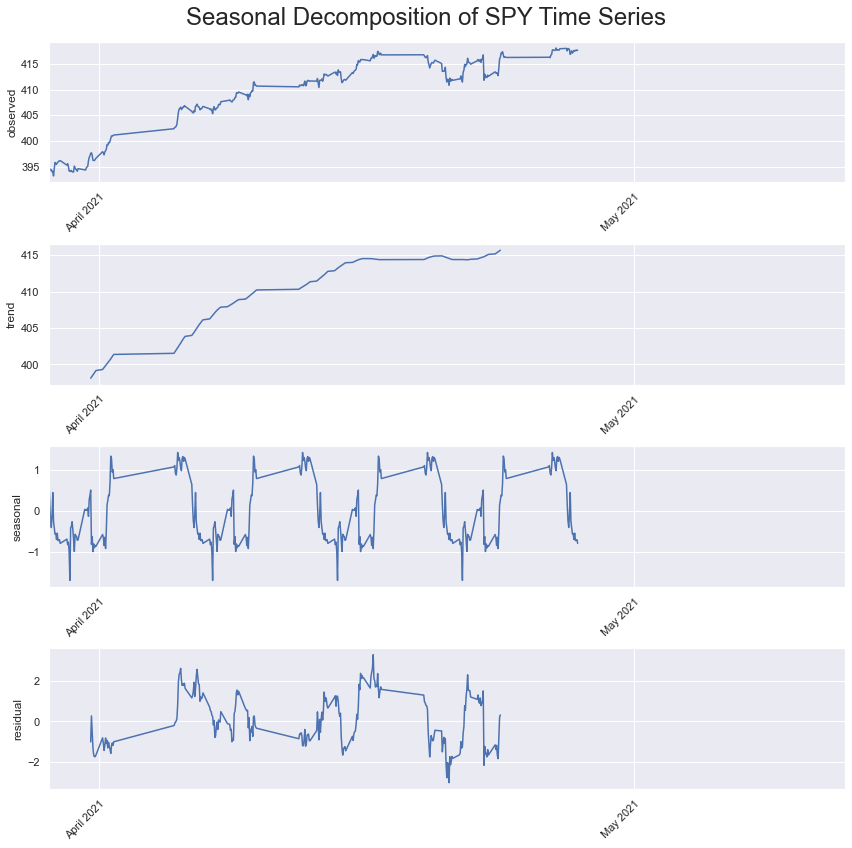

In [40]:
plot_seasonal_decomposition(df_last.dropna(), 'SPY', 16*5)

# Quandl

# Modeling

## SARIMA

In [ ]:
round((80/100)*len(df))

In [116]:
# df_train, df_test = train_test_split_data(df, 80)
df_train, df_test = train_test_split_data(df_last, 80)
ex_train, ex_test = train_test_split_data(vol_last, 80)

Using a 80/20 train-test split...
Using a 80/20 train-test split...


In [ ]:
param_list = []
param_seasonal_list = []
aic_list = []

In [1]:
param = (2,1,0)
param_seasonal = (2,1,0,2190)

In [23]:
# mod = SARIMAX(df_train,
#               order=param,
#               seasonal_order=param_seasonal,
#               enforce_stationarity=False,
#               enforce_invertibility=False,
#               verbose=True).fit()
# param_list.append(param)
# param_seasonal_list.append(param_seasonal)
# aic = mod.aic

In [24]:
# param_list, param_seasonal_list, aic_list = gridsearch_SARIMAX(df_train)

## Auto ARIMA

In [113]:
# pya.auto_arima(df.dropna(), seasonal=True, m=2190).summary()
# pya.auto_arima(df.dropna(), seasonal=True, m=round(365/4)).summary()
pya.auto_arima(df_last.dropna(), exog=vol_last).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  336
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -297.497
Date:                Wed, 28 Apr 2021   AIC                            600.993
Time:                        02:33:09   BIC                            612.436
Sample:                             0   HQIC                           605.555
                                - 336                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0800      0.035      2.287      0.022       0.011       0.148
ar.L1         -0.1210      0.048     -2.524      0.012      -0.215      -0.027
sigma2         0.3458      0.011     32.781      0.000       0.325       0.366
===================================================================================
Ljung-Box (Q):                       35.61   Jarque-Bera (JB):              3161.44
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
df_test

time
2021-04-21 15:00:00    414.9600
2021-04-21 16:00:00    416.0900
2021-04-21 17:00:00    415.3000
2021-04-21 18:00:00    415.2900
2021-04-21 19:00:00    415.2000
                         ...   
2021-04-27 16:00:00    417.4875
2021-04-27 17:00:00    417.6500
2021-04-27 18:00:00    417.5700
2021-04-27 19:00:00    417.7000
2021-04-27 20:00:00    417.6400
Freq: CBH, Name: close, Length: 70, dtype: float64

In [119]:
df_train.isna().index

DatetimeIndex(['2021-03-29 05:00:00', '2021-03-29 06:00:00',
               '2021-03-29 07:00:00', '2021-03-29 08:00:00',
               '2021-03-29 09:00:00', '2021-03-29 10:00:00',
               '2021-03-29 11:00:00', '2021-03-29 12:00:00',
               '2021-03-29 13:00:00', '2021-03-29 14:00:00',
               ...
               '2021-04-21 05:00:00', '2021-04-21 06:00:00',
               '2021-04-21 07:00:00', '2021-04-21 08:00:00',
               '2021-04-21 09:00:00', '2021-04-21 10:00:00',
               '2021-04-21 11:00:00', '2021-04-21 12:00:00',
               '2021-04-21 13:00:00', '2021-04-21 14:00:00'],
              dtype='datetime64[ns]', name='time', length=282, freq='CBH')

In [138]:
df_test

time
2021-04-21 15:00:00    414.9600
2021-04-21 16:00:00    416.0900
2021-04-21 17:00:00    415.3000
2021-04-21 18:00:00    415.2900
2021-04-21 19:00:00    415.2000
                         ...   
2021-04-27 16:00:00    417.4875
2021-04-27 17:00:00    417.6500
2021-04-27 18:00:00    417.5700
2021-04-27 19:00:00    417.7000
2021-04-27 20:00:00    417.6400
Freq: CBH, Name: close, Length: 70, dtype: float64

In [132]:
# sari_mod = SARIMAX(df_train.dropna(),order=(1,1,0),seasonal_order=(1,1,0,16), exog=ex_train.dropna()).fit()
sari_mod = SARIMAX(df_train, order=(1,1,0), seasonal_order=(1,1,0,16)).fit()
# sari_mod = SARIMAX(df_train,order=(1,1,0)).fit()
# results = sari_mod.fit()
sari_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              close   No. Observations:                  282
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 16)   Log Likelihood                -250.410
Date:                            Wed, 28 Apr 2021   AIC                            506.820
Time:                                    02:36:34   BIC                            517.559
Sample:                                03-29-2021   HQIC                           511.135
                                     - 04-21-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0610      0.052     -1.178      0.239      -0.163       0.041
ar.S.L16      -0.4420      0.059     -7.541      0.000      -0.557      -0.327
sigma2         0.4157      0.031     13.297      0.000       0.354       0.477
===================================================================================
Ljung-Box (Q):                       73.71   Jarque-Bera (JB):                16.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.00   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
df_test.index[0]

Timestamp('2021-04-21 15:00:00', freq='CBH')

In [133]:
y_hat_train = sari_mod.predict(typ='levels', dynamic=False)
y_hat_test = sari_mod.predict(start=df_test.index[0], end=df_test.index[-1], typ='levels')

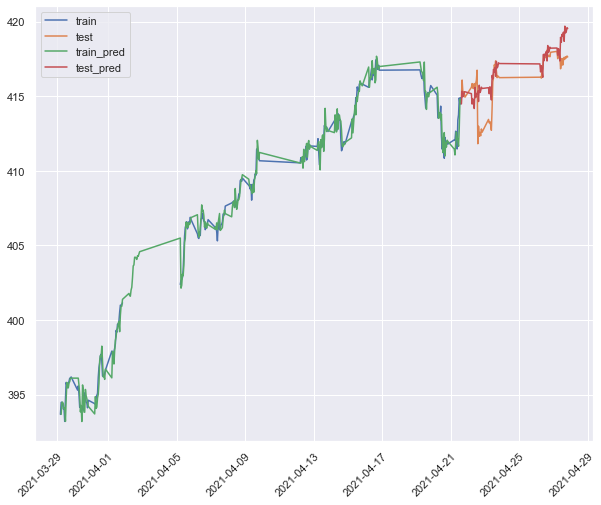

In [94]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train, label='train')
ax.plot(df_test, label='test')
ax.plot(y_hat_train[1:], label='train_pred')
ax.plot(y_hat_test, label='test_pred')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()

In [89]:
y_hat_train.idxmax()

Timestamp('2021-03-30 05:00:00', freq='CBH')

In [93]:
y_hat_train.max()

417.68456777779824

In [92]:
y_hat_train.drop(y_hat_train.idxmax(), inplace=True)

In [103]:
y_hat_test

2020-12-02 05:00:00    362.950811
2020-12-03 05:00:00    362.950811
2020-12-04 05:00:00    362.950811
2020-12-07 05:00:00    362.950811
2020-12-08 05:00:00    362.950811
                          ...    
2021-04-19 05:00:00    362.950811
2021-04-20 05:00:00    362.950811
2021-04-21 05:00:00    362.950811
2021-04-22 05:00:00    362.950811
2021-04-23 05:00:00    362.950811
Freq: C, Length: 103, dtype: float64

In [141]:
# sari_mod_last = SARIMAX(df_last,order=(1,1,0)).fit()
sari_mod_last = SARIMAX(df_last,order=(1,1,0),seasonal_order=(1,1,0,16)).fit()
sari_mod_last = SARIMAX(df_last.dropna(),order=(1,1,0),seasonal_order=(1,1,0,16), exog=vol_last.dropna()).fit()
# results = sari_mod.fit()
sari_mod_last.summary()

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              close   No. Observations:                  336
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 16)   Log Likelihood                -340.403
Date:                            Wed, 28 Apr 2021   AIC                            688.806
Time:                                    02:38:29   BIC                            703.867
Sample:                                         0   HQIC                           694.821
                                            - 336                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume     -6.718e-08   7.54e-09     -8.909      0.000    -8.2e-08   -5.24e-08
ar.L1         -0.1214      0.064     -1.905      0.057      -0.246       0.004
ar.S.L16      -0.4244      0.049     -8.650      0.000      -0.521      -0.328
sigma2         0.5925      0.044     13.473      0.000       0.506       0.679
===================================================================================
Ljung-Box (Q):                       73.89   Jarque-Bera (JB):               109.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [142]:
forecast = sari_mod_last.forecast(steps=16)

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

In [97]:
forecast

2021-04-28 05:00:00    417.717524
2021-04-28 06:00:00    417.445972
2021-04-28 07:00:00    417.675432
2021-04-28 08:00:00    417.866657
2021-04-28 09:00:00    417.836297
2021-04-28 10:00:00    417.699115
2021-04-28 11:00:00    417.900141
2021-04-28 12:00:00    418.076289
2021-04-28 13:00:00    417.792150
2021-04-28 14:00:00    418.010796
2021-04-28 15:00:00    418.301021
2021-04-28 16:00:00    418.032097
2021-04-28 17:00:00    418.162192
2021-04-28 18:00:00    418.122418
2021-04-28 19:00:00    418.154087
2021-04-28 20:00:00    418.254993
Freq: CBH, dtype: float64

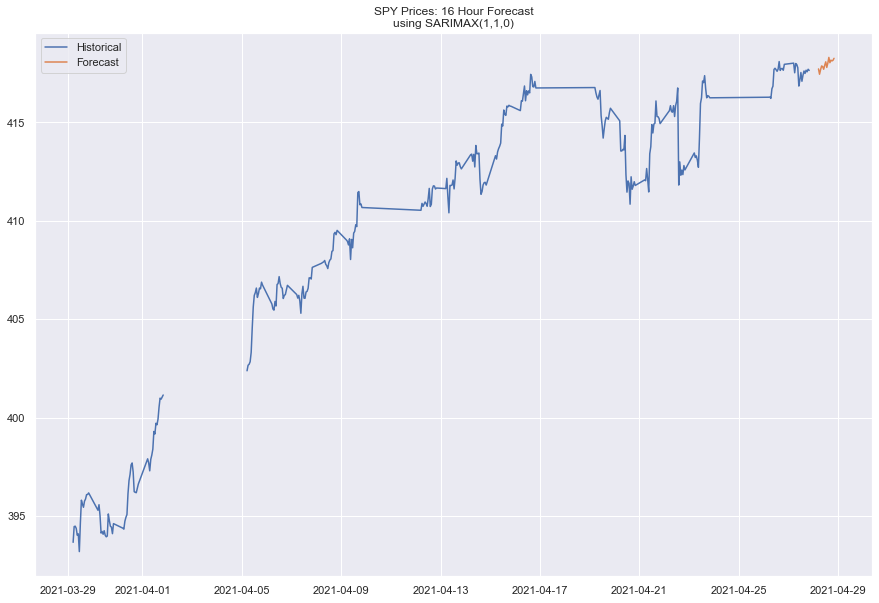

In [98]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(df_last.index, df_last, label='Historical')
ax.plot(forecast, label='Forecast')
ax.set_title('SPY Prices: 16 Hour Forecast\nusing SARIMAX(1,1,0)')
plt.legend()

## Facebook Prophet

In [41]:
df_pro = pd.DataFrame(df.reset_index())
df_pro.columns = ['ds','y']

In [42]:
df_pro

,ds,y
0,2019-05-07 05:00:00,281.033359
1,2019-05-07 06:00:00,280.956226
2,2019-05-07 07:00:00,280.483787
3,2019-05-07 08:00:00,280.136690
4,2019-05-07 09:00:00,280.368088
...,...,...
8219,2021-04-23 16:00:00,416.720000
8220,2021-04-23 17:00:00,416.250000
8221,2021-04-23 18:00:00,416.360000
8222,2021-04-23 19:00:00,416.330000


In [44]:
promod = prophet.Prophet()
promod.fit(df_pro)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [68]:
future = promod.make_future_dataframe(periods=16, freq=cbh)
future.tail(32)

,ds
8208,2021-04-23 05:00:00
8209,2021-04-23 06:00:00
8210,2021-04-23 07:00:00
8211,2021-04-23 08:00:00
8212,2021-04-23 09:00:00
8213,2021-04-23 10:00:00
8214,2021-04-23 11:00:00
8215,2021-04-23 12:00:00
8216,2021-04-23 13:00:00
8217,2021-04-23 14:00:00


In [50]:
forecast = promod.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
8235,2021-04-26 16:00:00,408.524646,401.382532,415.210783
8236,2021-04-26 17:00:00,408.583149,402.017356,415.542293
8237,2021-04-26 18:00:00,408.653672,401.983236,415.097077
8238,2021-04-26 19:00:00,408.728915,402.133891,415.699690
8239,2021-04-26 20:00:00,408.791958,401.862773,415.215570


In [67]:
df_pro[-16:]

,ds,y
8208,2021-04-23 05:00:00,413.4500
8209,2021-04-23 06:00:00,413.2200
8210,2021-04-23 07:00:00,413.3000
8211,2021-04-23 08:00:00,413.0800
8212,2021-04-23 09:00:00,412.7200
8213,2021-04-23 10:00:00,414.1800
8214,2021-04-23 11:00:00,415.9601
8215,2021-04-23 12:00:00,416.2505
8216,2021-04-23 13:00:00,417.1020
8217,2021-04-23 14:00:00,417.0200


In [55]:
forecast[-32:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8208,2021-04-23 05:00:00,407.328997,401.324610,413.972331,407.328997,407.328997,0.261961,0.261961,0.261961,0.110186,0.110186,0.110186,0.151775,0.151775,0.151775,0.0,0.0,0.0,407.590957
8209,2021-04-23 06:00:00,407.342424,401.317213,414.490884,407.342424,407.342424,0.266631,0.266631,0.266631,0.117386,0.117386,0.117386,0.149245,0.149245,0.149245,0.0,0.0,0.0,407.609056
8210,2021-04-23 07:00:00,407.355852,401.319105,414.545588,407.355852,407.355852,0.235127,0.235127,0.235127,0.087083,0.087083,0.087083,0.148044,0.148044,0.148044,0.0,0.0,0.0,407.590979
8211,2021-04-23 08:00:00,407.369280,401.097964,414.236356,407.369280,407.369280,0.204455,0.204455,0.204455,0.056388,0.056388,0.056388,0.148067,0.148067,0.148067,0.0,0.0,0.0,407.573734
8212,2021-04-23 09:00:00,407.382707,400.718841,414.097608,407.382707,407.382707,0.200718,0.200718,0.200718,0.051531,0.051531,0.051531,0.149186,0.149186,0.149186,0.0,0.0,0.0,407.583425
8213,2021-04-23 10:00:00,407.396135,401.391869,414.632759,407.396135,407.396135,0.225001,0.225001,0.225001,0.073751,0.073751,0.073751,0.151250,0.151250,0.151250,0.0,0.0,0.0,407.621136
8214,2021-04-23 11:00:00,407.409563,401.722477,414.259689,407.409563,407.409563,0.258693,0.258693,0.258693,0.104611,0.104611,0.104611,0.154081,0.154081,0.154081,0.0,0.0,0.0,407.668255
8215,2021-04-23 12:00:00,407.422991,400.844123,414.077044,407.422991,407.422991,0.280145,0.280145,0.280145,0.122662,0.122662,0.122662,0.157484,0.157484,0.157484,0.0,0.0,0.0,407.703136
8216,2021-04-23 13:00:00,407.436418,401.056927,414.086373,407.436418,407.436418,0.278486,0.278486,0.278486,0.117246,0.117246,0.117246,0.161241,0.161241,0.161241,0.0,0.0,0.0,407.714904
8217,2021-04-23 14:00:00,407.449846,400.604064,414.392686,407.449846,407.449846,0.256558,0.256558,0.256558,0.091440,0.091440,0.091440,0.165118,0.165118,0.165118,0.0,0.0,0.0,407.706404


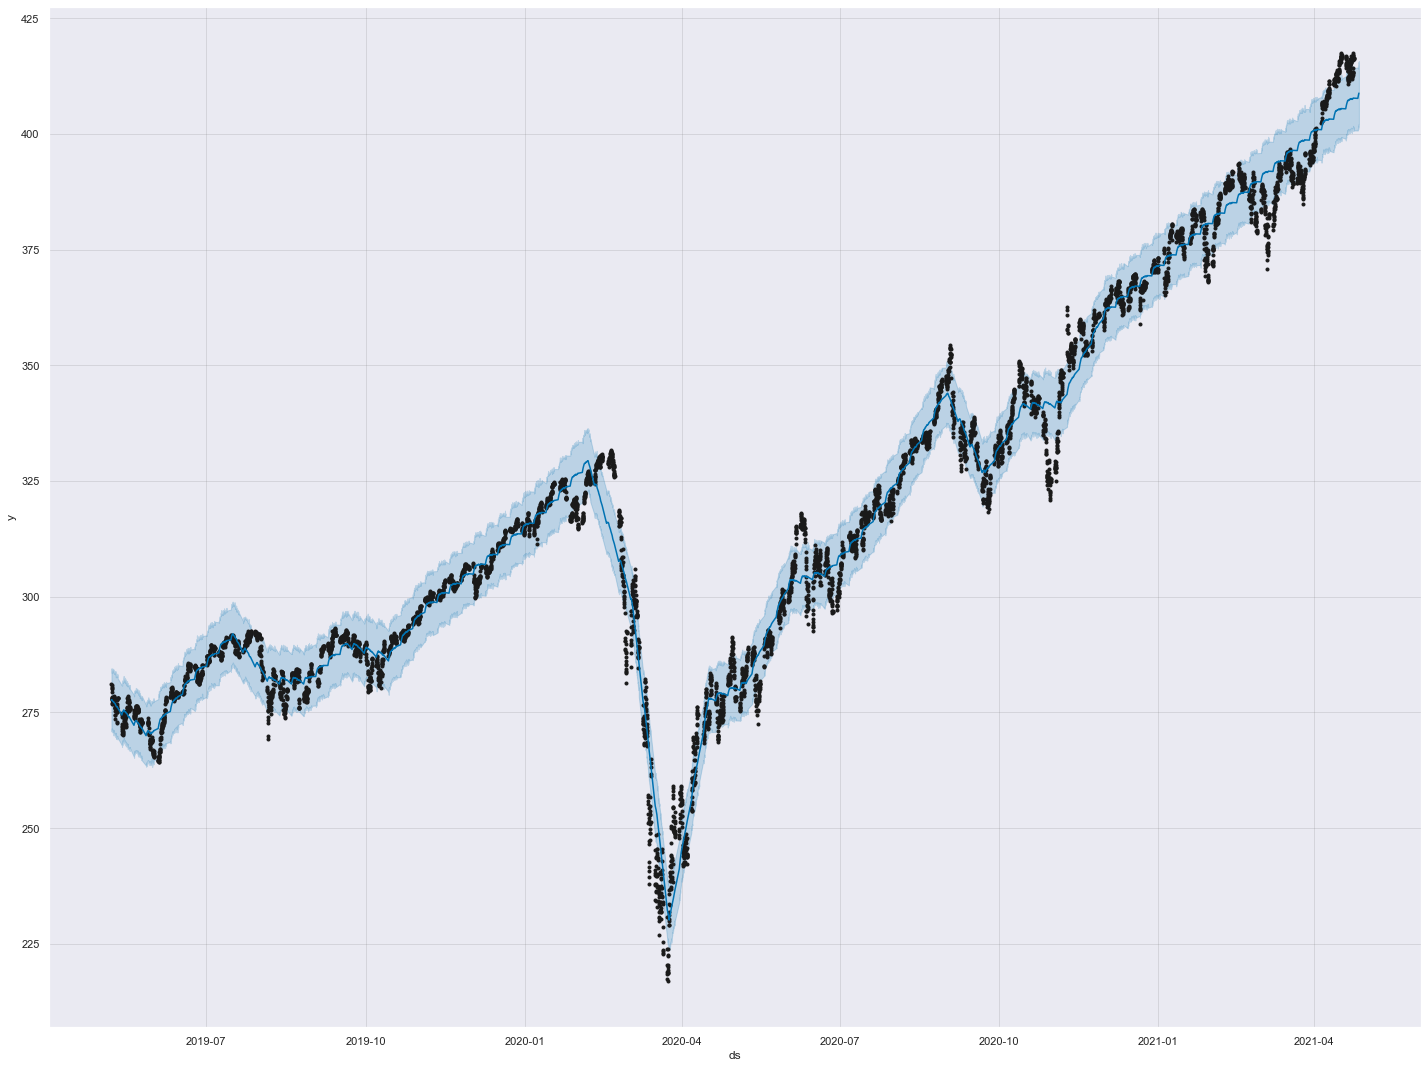

In [66]:
fig, ax = plt.subplots(figsize = (20,15))
promod.plot(forecast, ax=ax);
# start = pd.to_datetime('2021-04-23')
# end = pd.to_datetime('2021-04-26')
# ax.set_xlim(start,end)

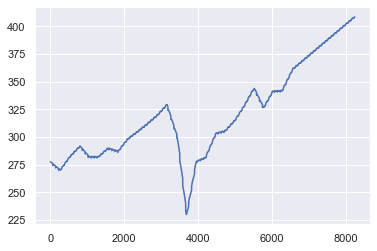

In [57]:
forecast.yhat.plot()

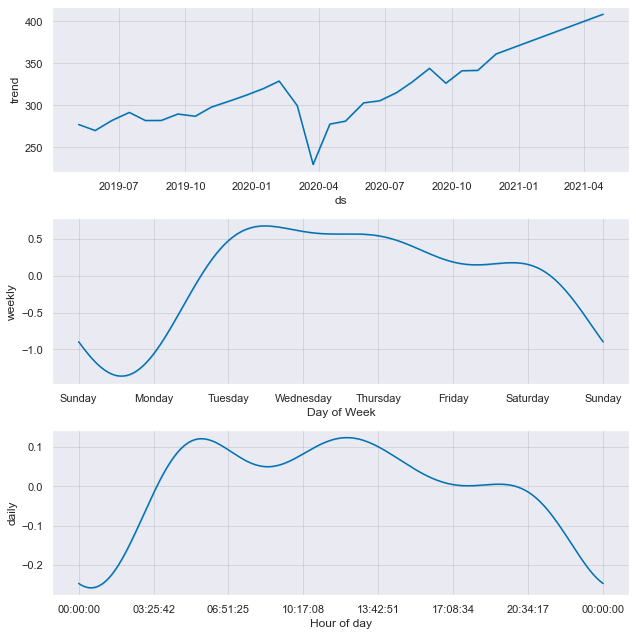

In [51]:
fig2 = promod.plot_components(forecast)
